In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from imblearn.ensemble import RUSBoostClassifier, BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier

In [ ]:
df = pd.read_excel('data.xlsx')
CLASS_COL = 'Churn'
df.set_index('customerID', inplace=True)
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,8672.45,No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,8477.60,No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,7990.05,No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,7365.70,No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,7804.15,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,Female,0,No,No,53,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,18.70,1005.70,No
7039,9945-PSVIP,Female,0,Yes,Yes,25,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,18.70,383.65,No
7040,0827-ITJPH,Male,0,No,No,36,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),18.55,689.00,No
7041,9764-REAFF,Female,0,Yes,No,59,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),18.40,1057.85,No


In [6]:
df['customerID'].value_counts()

customerID
7569-NMZYQ    1
8280-MQRQN    1
8992-JQYUN    1
9026-RNUJS    1
0096-BXERS    1
             ..
5383-MMTWC    1
2055-BFOCC    1
7233-PAHHL    1
3489-HHPFY    1
6823-SIDFQ    1
Name: count, Length: 7043, dtype: int64

# EDA

Contagem de NA

In [92]:
#contagem de NA
df.isna().sum().sort_values(ascending=False)

TotalCharges        11
gender               0
SeniorCitizen        0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
DeviceProtection     0
OnlineBackup         0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
tenure               0
Dependents           0
Partner              0
Churn                0
dtype: int64

In [93]:
df.dropna(inplace=True)

Contagem de valores churn

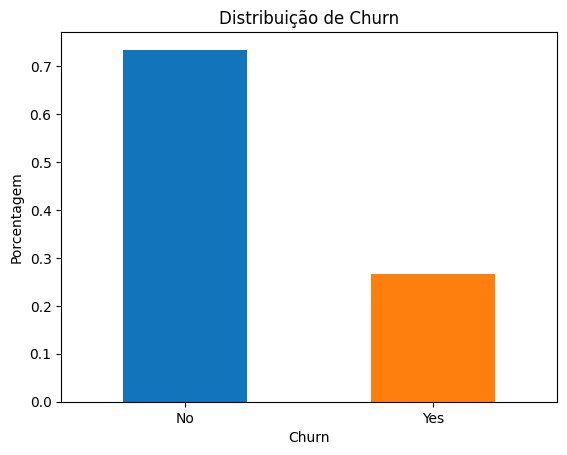

In [94]:
df[CLASS_COL].value_counts()
df[CLASS_COL].value_counts(normalize=True).plot(kind='bar', color=["#1274ba", '#ff7f0e'])
plt.title('Distribuição de Churn')
plt.xlabel(CLASS_COL)
plt.ylabel('Porcentagem')
plt.xticks(rotation=0)
plt.show()

Contagem de valores únicos por coluna

In [95]:
df.nunique().sort_values(ascending=True)

gender                 2
PaperlessBilling       2
PhoneService           2
Churn                  2
Partner                2
SeniorCitizen          2
Dependents             2
MultipleLines          3
InternetService        3
OnlineSecurity         3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
OnlineBackup           3
PaymentMethod          4
tenure                72
MonthlyCharges      1584
TotalCharges        6530
dtype: int64

Convertendo coluna alvo para booleanos

In [96]:
df[CLASS_COL] = df[CLASS_COL].replace({'Yes': True, 'No': False}).astype(bool)

<ipython-input-96-c3b84979c66a>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Dummy para colunas categóricas com poucas categorias

In [97]:
#dummy de colunas categóricas
dummy_cols = [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'PaperlessBilling',
    'PhoneService',
    'Contract',
    'StreamingMovies',
    'StreamingTV',
    'TechSupport',
    'OnlineBackup',
    'OnlineSecurity',
    'InternetService',
    'MultipleLines',
    'DeviceProtection',
    'PaymentMethod'
]
df_dummy = pd.get_dummies(df, columns=dummy_cols, drop_first=True)

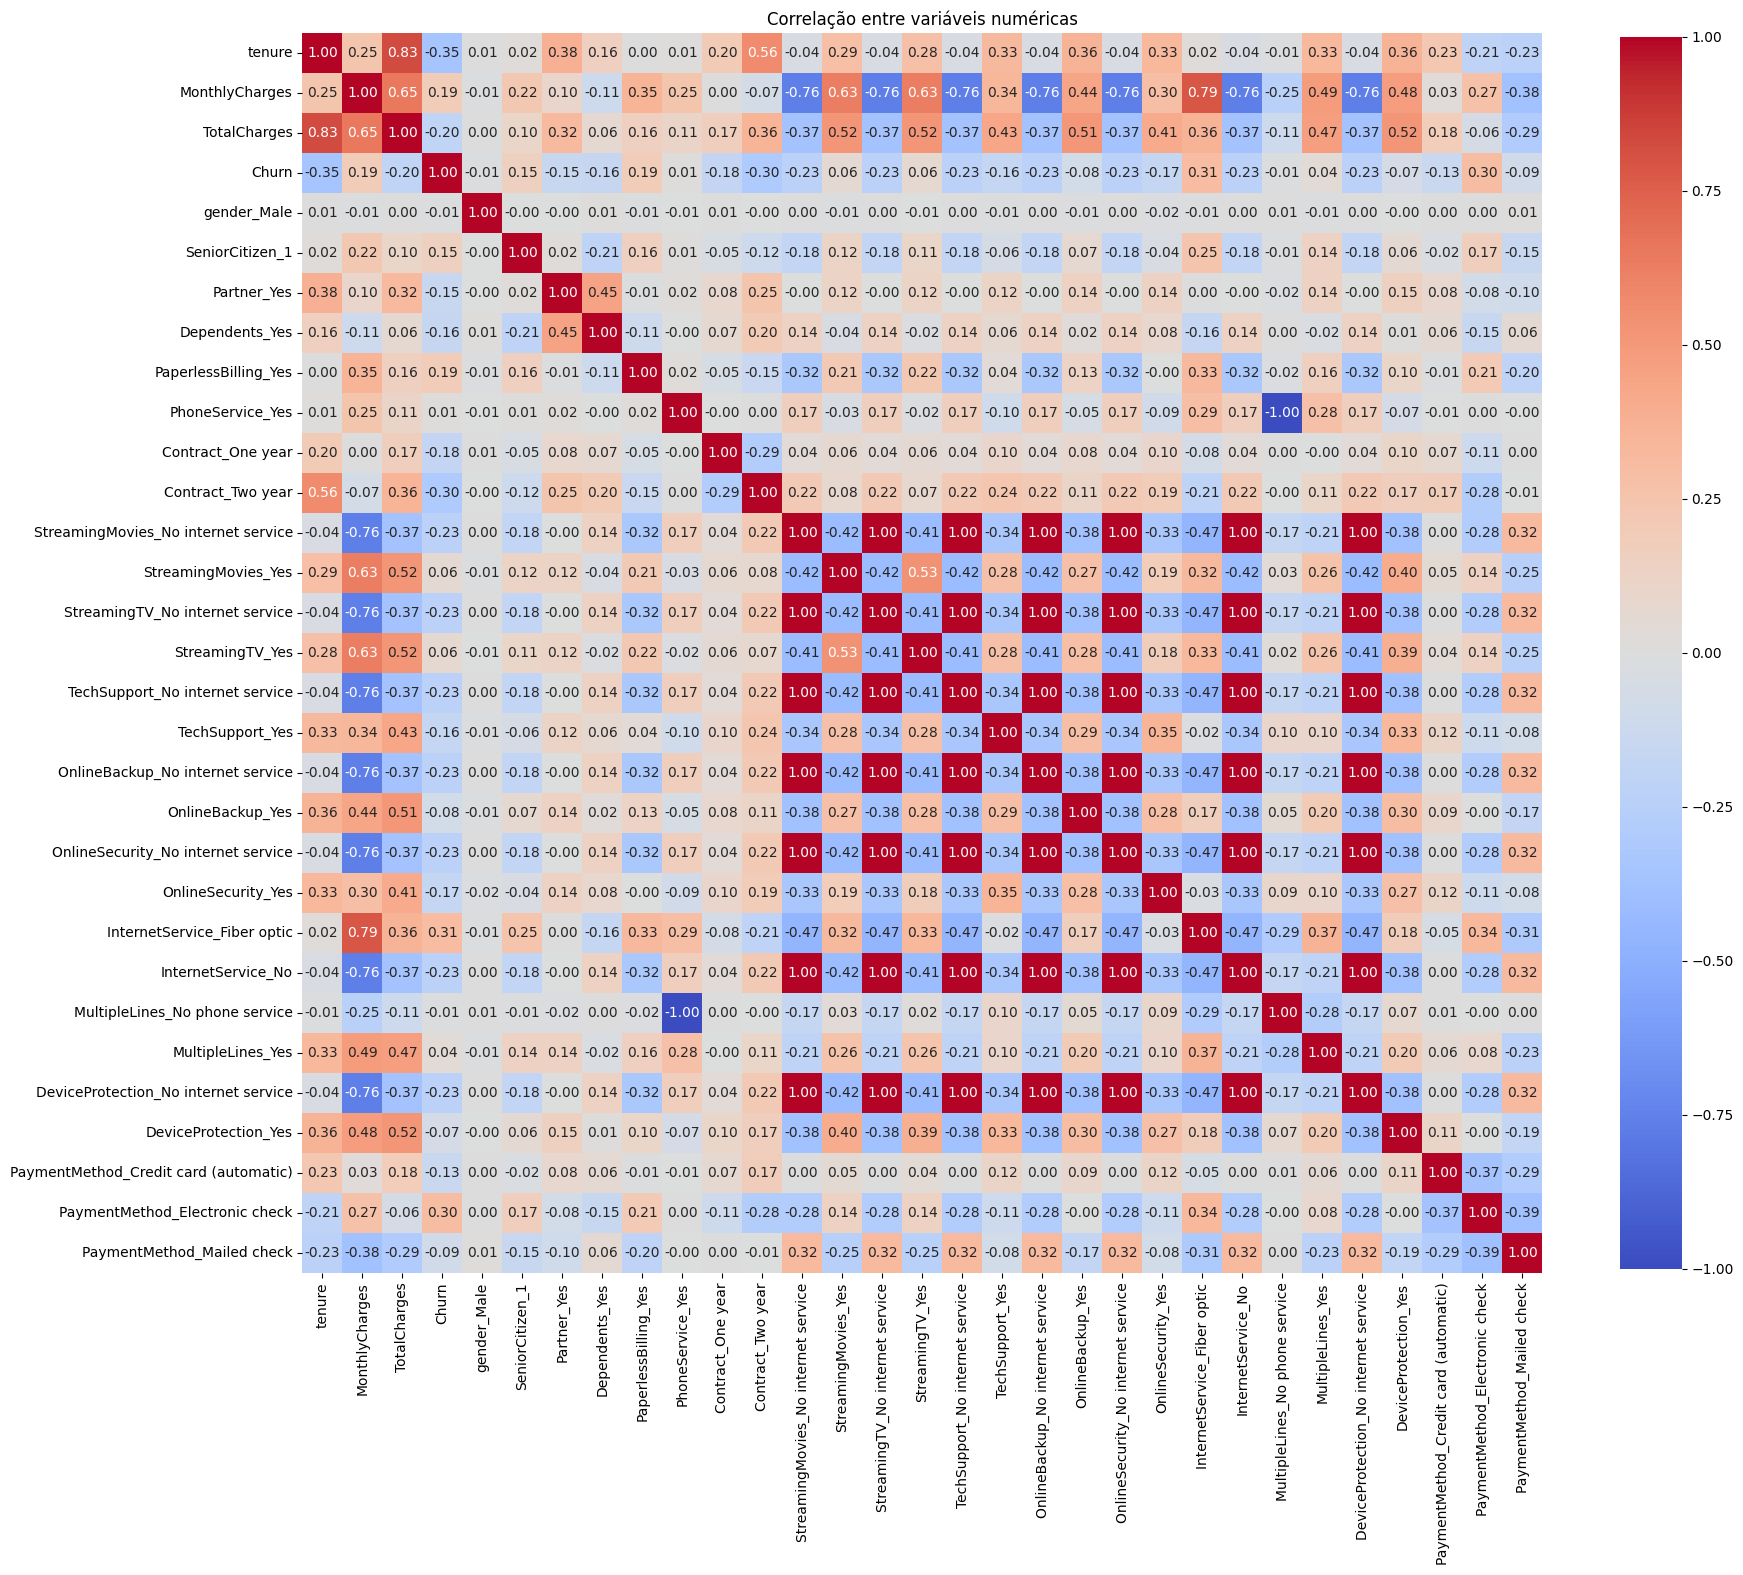

In [98]:
df_corr = df_dummy.corr(numeric_only=True)
plt.figure(figsize=(20, 20))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlação entre variáveis numéricas')
plt.show()


In [99]:
df_corr[CLASS_COL].sort_values(ascending=False)

Churn                                    1.000000
InternetService_Fiber optic              0.307463
PaymentMethod_Electronic check           0.301455
MonthlyCharges                           0.192858
PaperlessBilling_Yes                     0.191454
SeniorCitizen_1                          0.150541
StreamingTV_Yes                          0.063254
StreamingMovies_Yes                      0.060860
MultipleLines_Yes                        0.040033
PhoneService_Yes                         0.011691
gender_Male                             -0.008545
MultipleLines_No phone service          -0.011691
DeviceProtection_Yes                    -0.066193
OnlineBackup_Yes                        -0.082307
PaymentMethod_Mailed check              -0.090773
PaymentMethod_Credit card (automatic)   -0.134687
Partner_Yes                             -0.149982
Dependents_Yes                          -0.163128
TechSupport_Yes                         -0.164716
OnlineSecurity_Yes                      -0.171270


In [100]:
#separando os de correlação absoluta maior que 0.3
corr_threshold = 0.3
high_corr_features = df_corr[CLASS_COL][abs(df_corr[CLASS_COL]) > corr_threshold].index.tolist()

In [101]:
def drop_highly_correlated(df: pd.DataFrame,
                           class_col: str = CLASS_COL,
                           corr_threshold: float = 0.8,
                           class_corr_threshold: float = 0.3) -> pd.DataFrame:
    corr = df.corr().abs()

    #Identifica features ‘protegidas’ pela correlação com a classe
    corr_with_class = corr[class_col].drop(class_col)
    protected = set(corr_with_class[corr_with_class > class_corr_threshold].index)

    #Submatriz só com features (sem class_col)
    features = [c for c in df.columns if c != class_col]
    corr_feat = corr.loc[features, features]

    #Mantém apenas o triângulo superior
    mask = np.triu(np.ones(corr_feat.shape), k=1).astype(bool)
    upper = corr_feat.where(mask)

    high_corr = (
        upper.stack()
             .reset_index()
             .rename(columns={'level_0':'f1', 'level_1':'f2', 0:'corr'})
    )
    high_corr = high_corr[high_corr['corr'] > corr_threshold]

    #Decide qual coluna dropar em cada par
    def choose_drop(row):
        f1, f2 = row['f1'], row['f2']
        # se ambos protegidos, mantém o de maior correlação com a classe
        if f1 in protected and f2 in protected:
            return f2 if corr_with_class[f1] > corr_with_class[f2] else f1
        # se um for protegido, droppa o outro
        if f1 in protected:
            return f2
        if f2 in protected:
            return f1
        # nenhum protegido: dropa f2 (arbitrário)
        return f2

    to_drop = set(high_corr.apply(choose_drop, axis=1))

    print(f"Colunas removidas ({len(to_drop)}): {to_drop}")
    return df.drop(columns=to_drop)

df_reduced = drop_highly_correlated(df_dummy)
print("DataFrame original:", df_dummy.shape)
print("DataFrame reduzido:", df_reduced.shape)

Colunas removidas (8): {'DeviceProtection_No internet service', 'OnlineSecurity_No internet service', 'InternetService_No', 'OnlineBackup_No internet service', 'StreamingTV_No internet service', 'TotalCharges', 'TechSupport_No internet service', 'MultipleLines_No phone service'}
DataFrame original: (7032, 31)
DataFrame reduzido: (7032, 23)


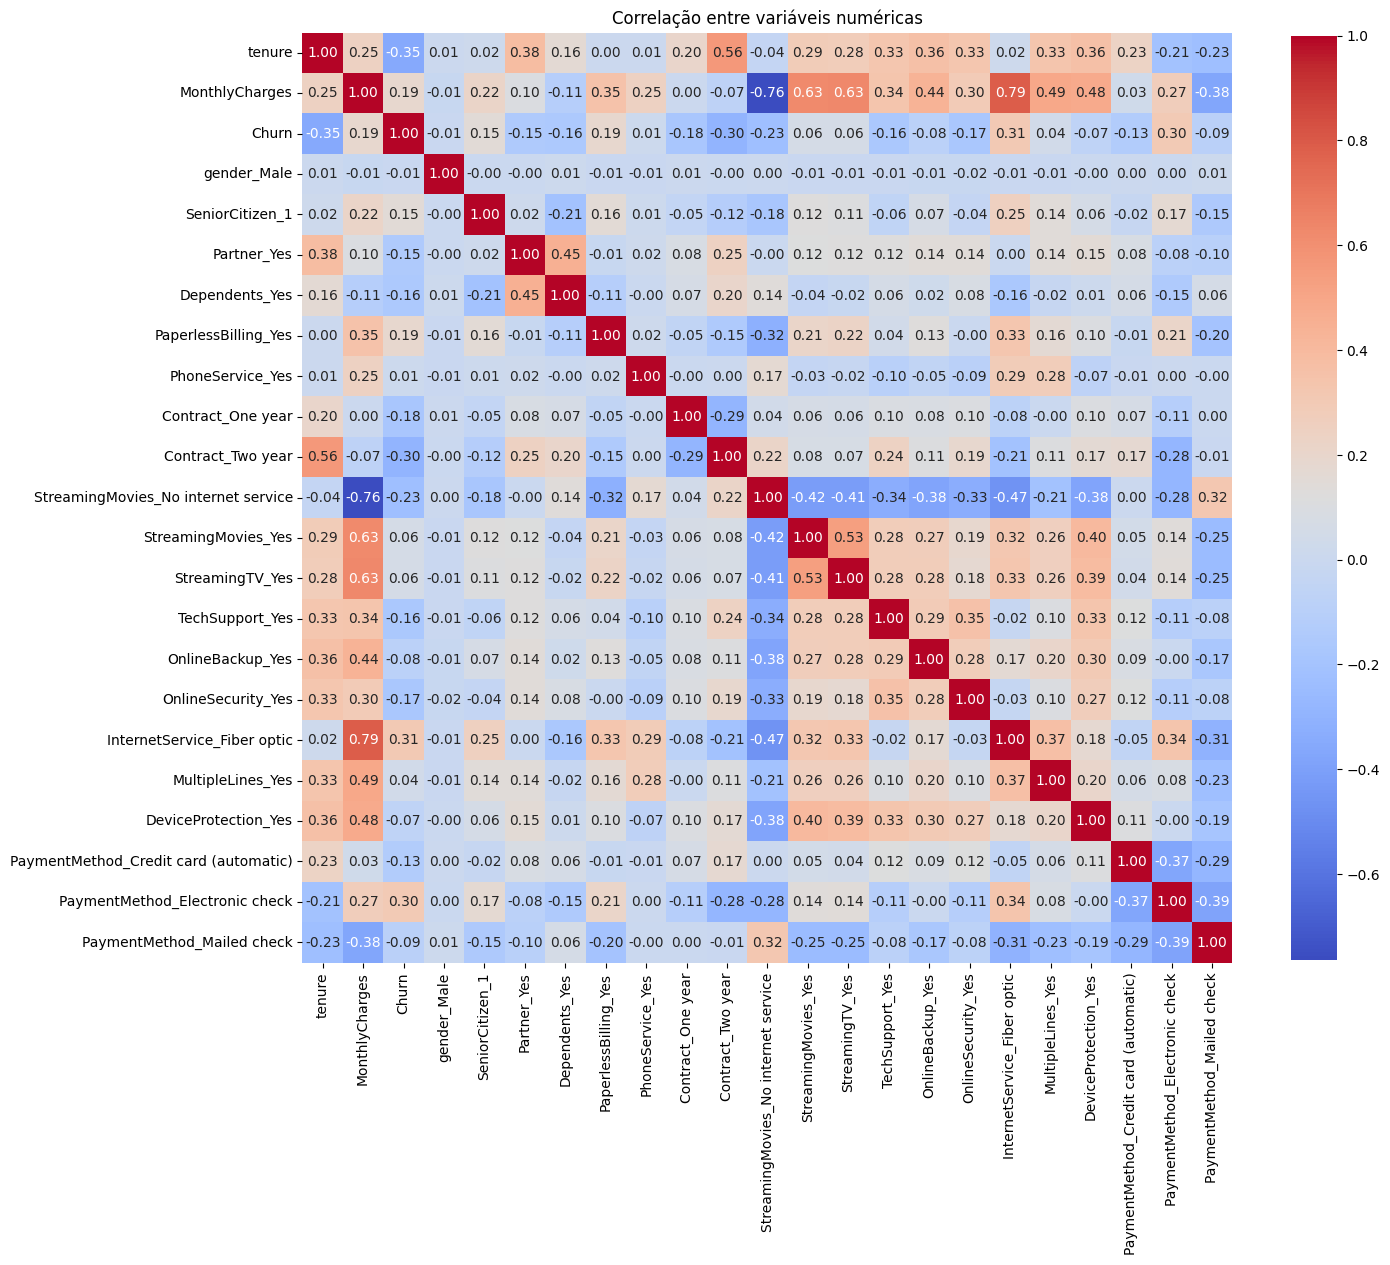

In [102]:
df_reduced_corr = df_reduced.corr(numeric_only=True)
plt.figure(figsize=(15, 15))
sns.heatmap(df_reduced_corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlação entre variáveis numéricas')
plt.show()

Obtendo importância de features

In [103]:
X = df_reduced.drop(columns=CLASS_COL)
y = df_reduced[CLASS_COL]

brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=5,
    max_depth=10
)

brf.fit(X, y)
importances = pd.Series(
    brf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importances)

colunas_importantes = importances[importances > 0.02].index
print(f"Colunas removidas ({len(importances) - len(colunas_importantes)}): {importances[importances <= 0.02].index}")


df_reduced = df_reduced[[CLASS_COL, *colunas_importantes]]

tenure                                   0.234480
Contract_Two year                        0.162772
MonthlyCharges                           0.120540
InternetService_Fiber optic              0.078048
PaymentMethod_Electronic check           0.058036
Contract_One year                        0.056361
StreamingMovies_No internet service      0.051190
OnlineSecurity_Yes                       0.029314
PaperlessBilling_Yes                     0.026831
TechSupport_Yes                          0.023923
Dependents_Yes                           0.018247
Partner_Yes                              0.017015
StreamingMovies_Yes                      0.015704
gender_Male                              0.014778
OnlineBackup_Yes                         0.013972
PaymentMethod_Credit card (automatic)    0.013859
StreamingTV_Yes                          0.013605
DeviceProtection_Yes                     0.012187
MultipleLines_Yes                        0.012071
SeniorCitizen_1                          0.010039


In [104]:
df_reduced.columns

Index(['Churn', 'tenure', 'Contract_Two year', 'MonthlyCharges',
       'InternetService_Fiber optic', 'PaymentMethod_Electronic check',
       'Contract_One year', 'StreamingMovies_No internet service',
       'OnlineSecurity_Yes', 'PaperlessBilling_Yes', 'TechSupport_Yes'],
      dtype='object')

In [105]:
#PCA em df_reduced
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_reduced.drop(columns=CLASS_COL))
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2','PC3'])
df_pca[CLASS_COL] = df_reduced[CLASS_COL].values


In [106]:
df_pca

,PC1,PC2,PC3,Churn
0,65.663835,12.921088,0.480222,False
1,65.151017,12.050944,0.063666,False
2,63.824161,9.368291,0.895355,False
3,60.857196,3.012875,0.058610,False
4,63.177122,8.557475,0.419065,True
...,...,...,...,...
7027,-33.001378,38.222186,-0.200184,False
7028,-44.890473,12.873333,-0.266942,False
7029,-40.353650,22.893865,-0.387596,False
7030,-30.724232,43.780578,-0.266970,False


In [107]:
#scatter plot de todas as colunas (num grid) diferenciando os pontos pelos valores de churn

import plotly.express as px
df = px.data.tips()
#possiveis combinacoes 2 a 2 de colunas exceto CLASS_COL, retorne uma lista de tuplas com os nomes das colunas
combinations = [(col1, col2) for i, col1 in enumerate(df_pca.columns) for col2 in df_pca.columns[i+1:] if col1 != CLASS_COL and col2 != CLASS_COL]
#scatter plot de todas as colunas (num grid) diferenciando os pontos pelos valores de churn

import plotly.express as px
df = px.data.tips()
#possiveis combinacoes 2 a 2 de colunas exceto CLASS_COL, retorne uma lista de tuplas com os nomes das colunas
combinations = [(col1, col2) for i, col1 in enumerate(df_pca.columns) 
                                for col2 in df_pca.columns[i+1:] 
                                    if col1 != CLASS_COL and col2 != CLASS_COL]
for col1, col2 in combinations:
    fig = px.scatter(df_pca, x=col1, y=col2, color=CLASS_COL)
    fig.update_layout(title=f'Scatter plot de {col1} vs {col2}')
    fig.show()

In [108]:
#split em treino e teste
from sklearn.model_selection import train_test_split
X = df_reduced.drop(columns=CLASS_COL)
y = df_reduced[CLASS_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [109]:
#BalancedRandomForestClassifier
# Definindo o scorer para o GridSearchCV
#

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print("ROC-AUC (test):", roc_auc_score(y_test, y_pred_proba))
    print("Classification report (test):")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix (test):")

    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for cm_it, tit in [(cm, ''), (cm_norm, ' Normalizada')]:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_it, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                    xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])

        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confusão{tit}')
        plt.show()

def get_best_model(param_grid, pipe, X_train, y_train, folds=5, scorer='roc_auc'):
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42) # StratifiedKFold pois se trata de classificação, tal método mantém a proporção das classes nos folds

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        verbose=3
    )

    grid_search.fit(X_train, y_train)

    print("Melhores parâmetros:", grid_search.best_params_)
    print("Melhor Score:", grid_search.best_score_)

    return  grid_search.best_estimator_

BalancedRandomForestClassifier

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Melhores parâmetros: {'clf__max_depth': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 10, 'clf__replacement': True, 'clf__sampling_strategy': 1.0}
Melhor Score: 0.854180602006689
ROC-AUC (test): 0.8191006931682293
Classification report (test):
              precision    recall  f1-score   support

       False       0.93      0.61      0.74      1033
        True       0.45      0.88      0.60       374

    accuracy                           0.68      1407
   macro avg       0.69      0.75      0.67      1407
weighted avg       0.81      0.68      0.70      1407

Confusion matrix (test):


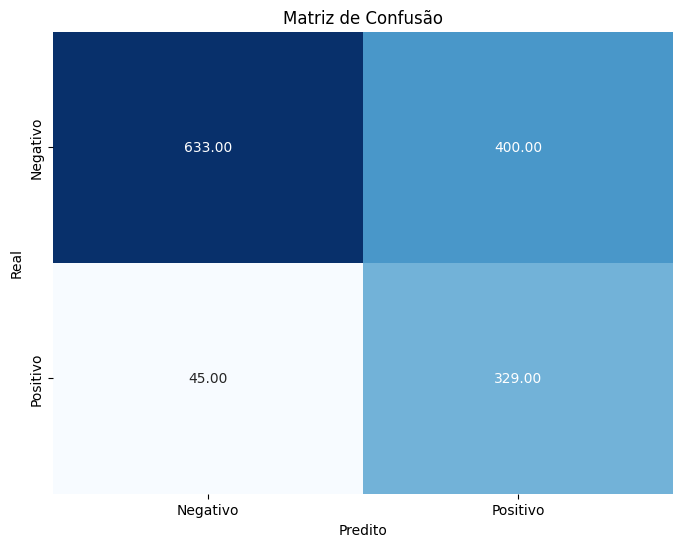

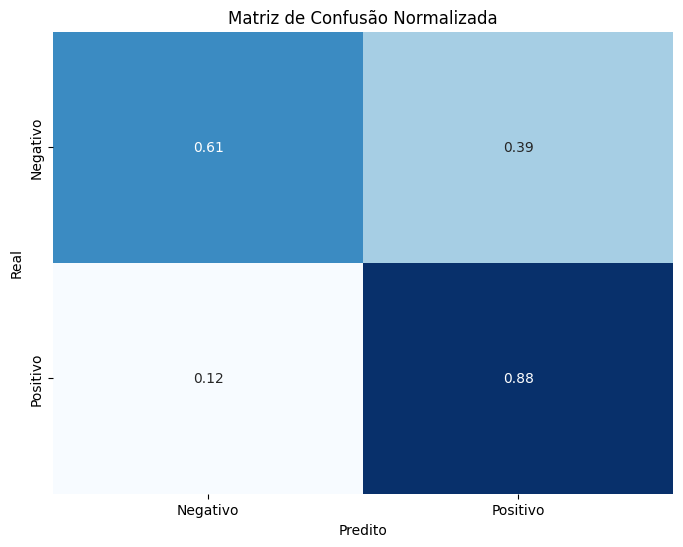

In [110]:
pipe = Pipeline([
    ('clf', BalancedRandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    'clf__n_estimators': [10, 25, 50, 100, 200, 250],
    'clf__max_depth': [None,2, 5, 10, 20],
    'clf__min_samples_split': [2, 3, 5],
    'clf__sampling_strategy': [0.5, 0.75, 1.0, 'auto'],  # valores possíveis: 'auto', float, dict, etc.
    'clf__replacement': [False, True]
}

best_random_forest_recall = get_best_model(param_grid, pipe, X_train, y_train, scorer='recall')

evaluate_model(best_random_forest_recall, X_test, y_test)

Trocando para f1 score

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Melhores parâmetros: {'clf__max_depth': 5, 'clf__min_samples_split': 3, 'clf__n_estimators': 100, 'clf__replacement': True, 'clf__sampling_strategy': 0.75}
Melhor Score: 0.6350084078915949
ROC-AUC (test): 0.8454309911943304
Classification report (test):
              precision    recall  f1-score   support

       False       0.89      0.80      0.84      1033
        True       0.57      0.73      0.64       374

    accuracy                           0.78      1407
   macro avg       0.73      0.77      0.74      1407
weighted avg       0.81      0.78      0.79      1407

Confusion matrix (test):


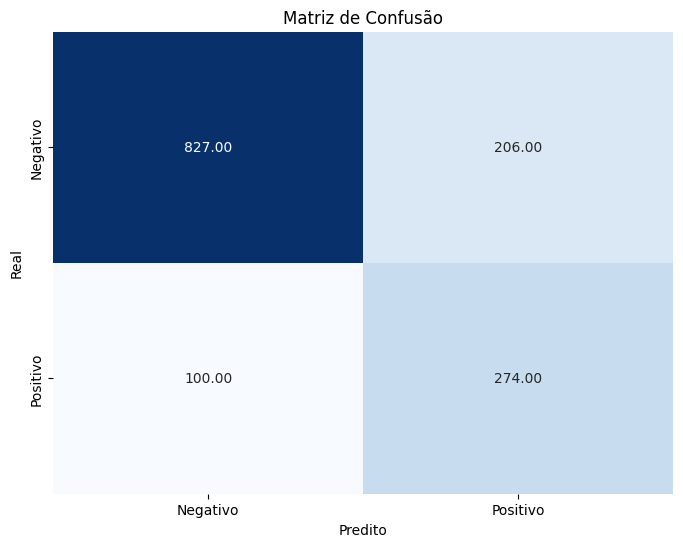

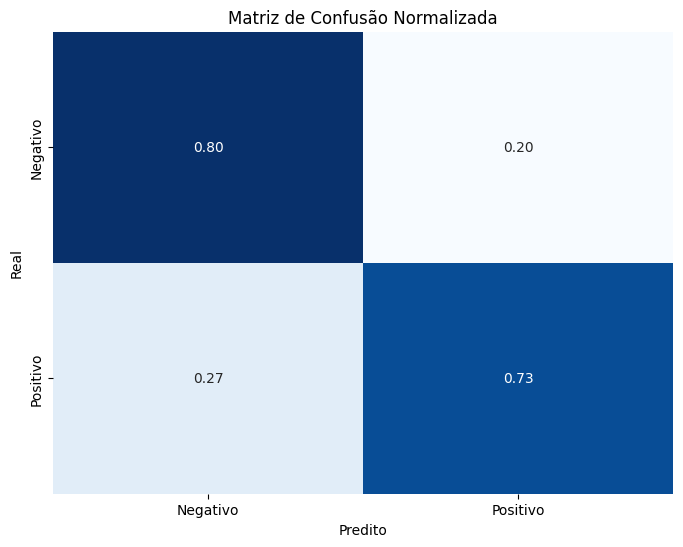

In [111]:
pipe = Pipeline([
    ('clf', BalancedRandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    'clf__n_estimators': [10, 25, 50, 100, 200, 250],
    'clf__max_depth': [None, 2, 5, 10, 20],
    'clf__min_samples_split': [2, 3, 5],
    'clf__sampling_strategy': [0.5, 0.75, 1.0, 'auto'],  # valores possíveis: 'auto', float, dict, etc.
    'clf__replacement': [False, True]
}

best_random_forest_f1 = get_best_model(param_grid, pipe, X_train, y_train, scorer='f1')

evaluate_model(best_random_forest_f1, X_test, y_test)

### RUSBoostClassifier

Fitting 5 folds for each of 490 candidates, totalling 2450 fits


C:\Users\digom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


1190 fits failed out of a total of 2450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\digom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\digom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\loca

Melhores parâmetros: {'rus__learning_rate': 2, 'rus__n_estimators': 40, 'rus__sampling_strategy': 0.4}
Melhor Score: 0.9759197324414716
ROC-AUC (test): 0.6422340827556932
Classification report (test):
              precision    recall  f1-score   support

       False       0.96      0.32      0.48      1033
        True       0.34      0.97      0.50       374

    accuracy                           0.49      1407
   macro avg       0.65      0.64      0.49      1407
weighted avg       0.80      0.49      0.48      1407

Confusion matrix (test):


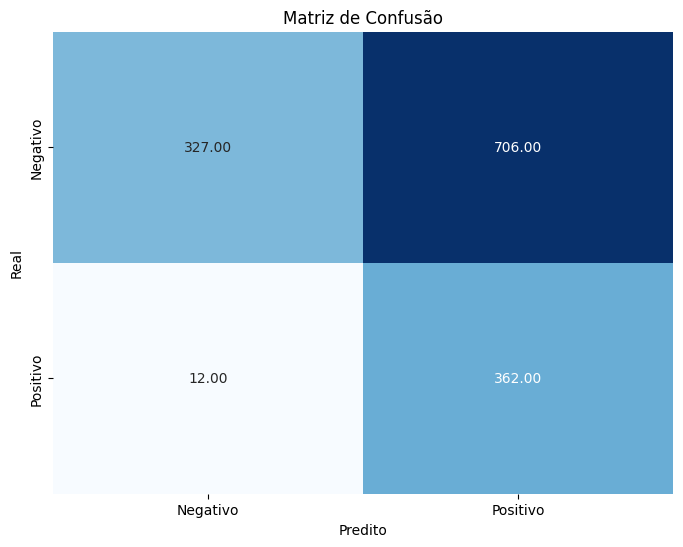

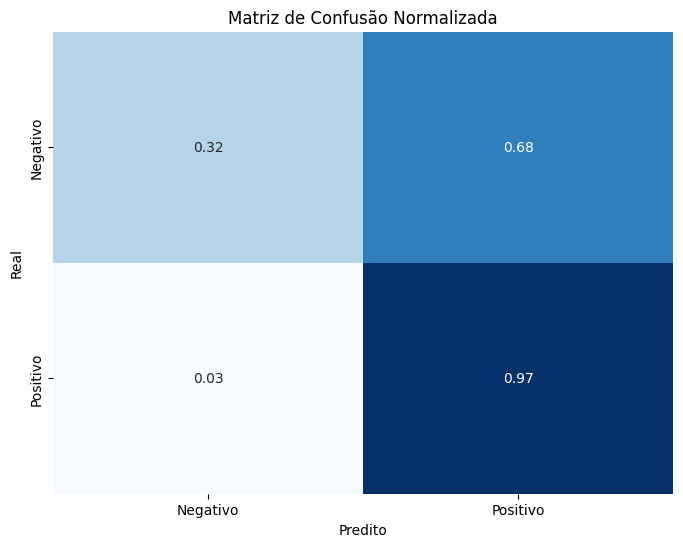

In [112]:
pipe = Pipeline([
    ('rus', RUSBoostClassifier(random_state=42))
])

param_grid = {
    'rus__n_estimators': [25, 40, 50, 60, 100, 150, 200],
    'rus__learning_rate': [0.001, 0.02, 0.1, 0.5, 1.0, 1.5, 2, 2.5, 3, 3.5],
    'rus__sampling_strategy': [0.3, 0.4, 0.5, 0.6, 0.75, 1.0, 'auto']
}

best_rus_recall = get_best_model(param_grid, pipe,  X_train, y_train, scorer='recall')

evaluate_model(best_rus_recall, X_test, y_test)

Trocando o método de avaliação para F1 Score

Fitting 5 folds for each of 490 candidates, totalling 2450 fits


C:\Users\digom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


1190 fits failed out of a total of 2450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\digom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\digom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\loca

Melhores parâmetros: {'rus__learning_rate': 1.5, 'rus__n_estimators': 40, 'rus__sampling_strategy': 0.4}
Melhor Score: 0.5966111169388334
ROC-AUC (test): 0.8353686629980691
Classification report (test):
              precision    recall  f1-score   support

       False       0.83      0.89      0.86      1033
        True       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Confusion matrix (test):


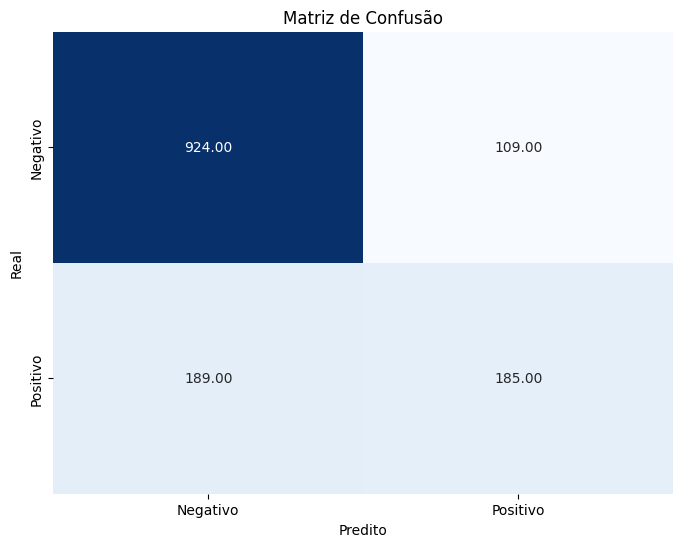

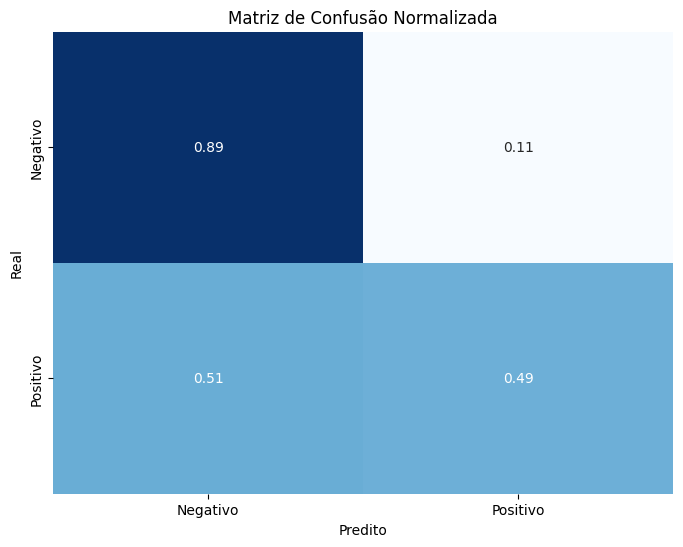

In [113]:
pipe = Pipeline([
    ('rus', RUSBoostClassifier(random_state=42))
])

param_grid = {
    'rus__n_estimators': [25, 40, 50, 60, 100, 150, 200],
    'rus__learning_rate': [0.001, 0.02, 0.1, 0.5, 1.0, 1.5, 2, 2.5, 3, 3.5],
    'rus__sampling_strategy': [0.3, 0.4, 0.5, 0.6, 0.75, 1.0, 'auto']
}

best_rus_f1 = get_best_model(param_grid, pipe,  X_train, y_train, scorer='f1')

evaluate_model(best_rus_f1, X_test, y_test)

## BalancedBaggingClassifier

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Melhores parâmetros: {'bbc__bootstrap_features': True, 'bbc__n_estimators': 250, 'bbc__replacement': True, 'bbc__sampling_strategy': 1.0}
Melhor Score: 0.7759197324414716
ROC-AUC (test): 0.8375584326839951
Classification report (test):
              precision    recall  f1-score   support

       False       0.89      0.75      0.81      1033
        True       0.52      0.75      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407

Confusion matrix (test):


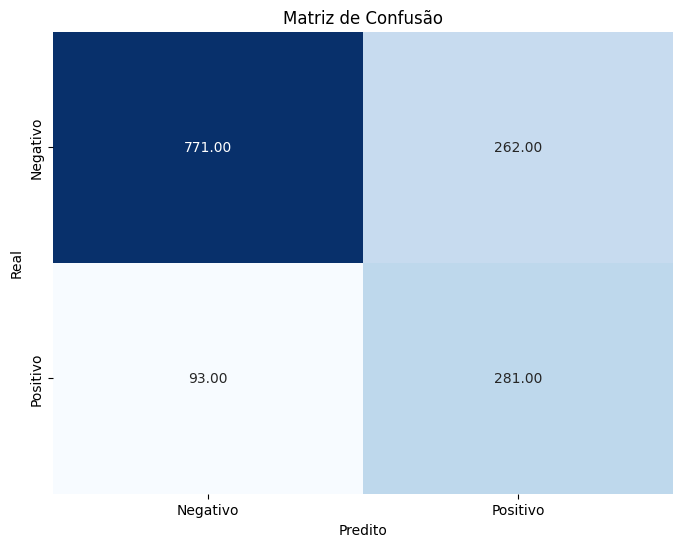

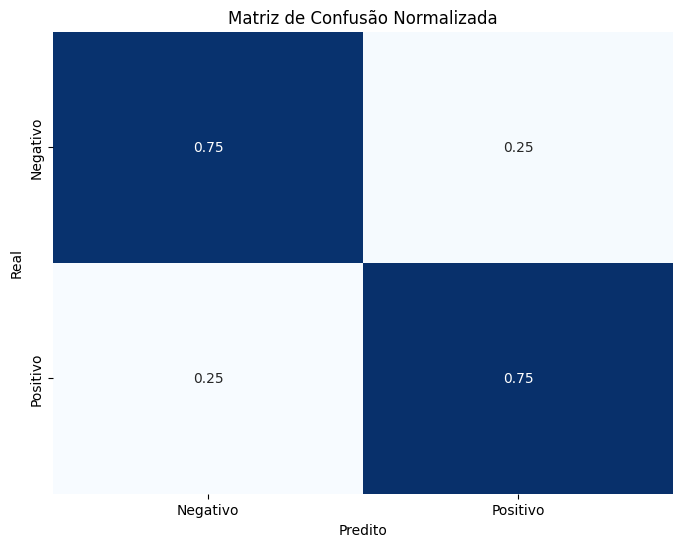

In [114]:
pipe = Pipeline([
    ('bbc', BalancedBaggingClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    'bbc__n_estimators': [100, 200, 250, 300, 350, 400, 450],
    'bbc__sampling_strategy': [0.5, 0.75, 1.0, 'auto'],
    'bbc__replacement': [False, True],
    'bbc__bootstrap_features': [False, True]
}

best_bbc_recall = get_best_model(param_grid, pipe,  X_train, y_train, scorer='recall')
evaluate_model(best_bbc_recall, X_test, y_test)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Melhores parâmetros: {'bbc__bootstrap_features': True, 'bbc__n_estimators': 300, 'bbc__replacement': False, 'bbc__sampling_strategy': 1.0}
Melhor Score: 0.6241147203543868
ROC-AUC (test): 0.8359678730244189
Classification report (test):
              precision    recall  f1-score   support

       False       0.89      0.78      0.83      1033
        True       0.54      0.72      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407

Confusion matrix (test):


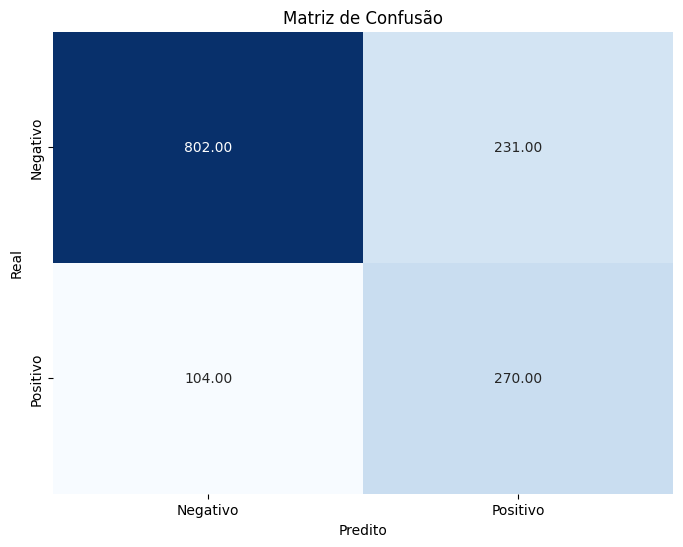

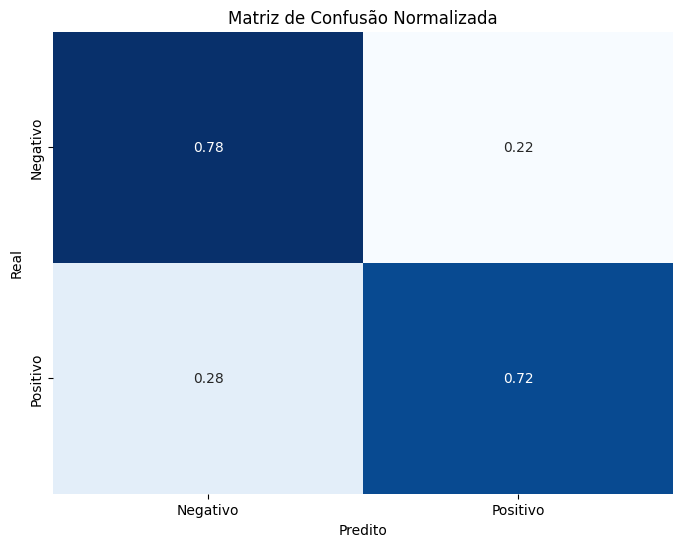

In [115]:
pipe = Pipeline([
    ('bbc', BalancedBaggingClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    'bbc__n_estimators': [100, 200, 250, 300, 350, 400, 450],
    'bbc__sampling_strategy': [0.5, 0.75, 1.0, 'auto'],
    'bbc__replacement': [False, True],
    'bbc__bootstrap_features': [False, True]
}

best_bbc_f1 = get_best_model(param_grid, pipe,  X_train, y_train, scorer='f1')
evaluate_model(best_bbc_f1, X_test, y_test)

## VotingClassifier

In [116]:
models_list = [
    ('brfc_recall', best_random_forest_recall),
    ('brfc_f1', best_random_forest_f1),
    ('bbc_recall', best_bbc_recall),
    ('bbc_f1', best_bbc_f1),
    ('rus_f1', best_rus_f1), 
    ('rus_recall', best_rus_recall)]

#combinação 2 a 2 da models_list
from itertools import combinations
combinations_list_2 = [list(comb) for comb in list(combinations(models_list, 2))]
#combinação 3 a 3 da models_list
combinations_list_3 = [list(comb) for comb in list(combinations(models_list, 3))]
#combinação 4 a 4 da models_list
combinations_list_4 = [list(comb) for comb in list(combinations(models_list, 4))]
#combinação 5 a 5 da models_list
combinations_list_5 = [list(comb) for comb in list(combinations(models_list, 5))]

Fitting 5 folds for each of 114 candidates, totalling 570 fits
Melhores parâmetros: {'vot__estimators': [('brfc_recall', Pipeline(steps=[('clf',
                 BalancedRandomForestClassifier(max_depth=2, n_estimators=10,
                                                n_jobs=-1, random_state=42,
                                                sampling_strategy=1.0))])), ('rus_recall', Pipeline(steps=[('rus',
                 RUSBoostClassifier(learning_rate=2, n_estimators=40,
                                    random_state=42, sampling_strategy=0.4))]))], 'vot__flatten_transform': True, 'vot__voting': 'soft'}
Melhor Score: 0.8575250836120402
ROC-AUC (test): 0.8191006931682293
Classification report (test):
              precision    recall  f1-score   support

       False       0.93      0.61      0.74      1033
        True       0.45      0.88      0.60       374

    accuracy                           0.68      1407
   macro avg       0.69      0.75      0.67      1407
weighted 

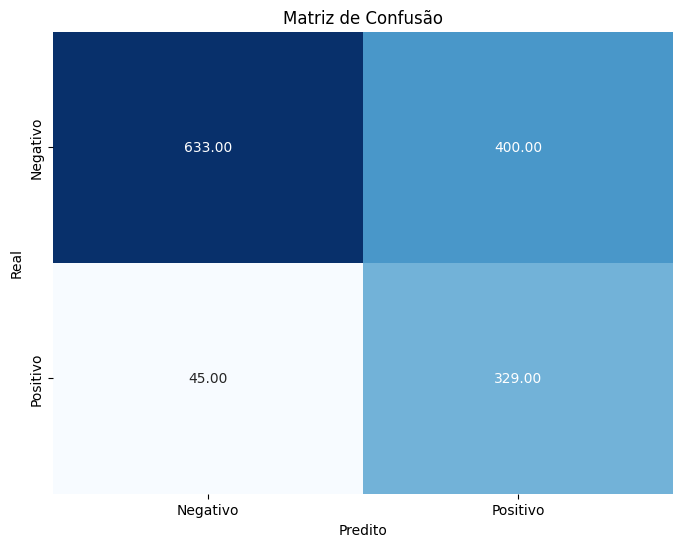

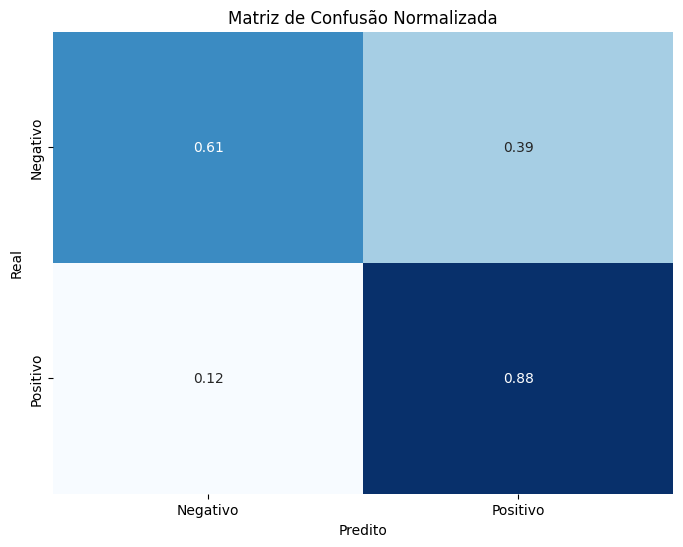

In [122]:
#combinando os dois melhores modelos
pipe = Pipeline([
    ('vot', VotingClassifier(estimators=models_list, n_jobs=-1))
])

param_grid = {
    'vot__estimators':[*[*combinations_list_2],
                        *[*combinations_list_3],
                       *[*combinations_list_4],
                       *[*combinations_list_5],
                       models_list],
    'vot__voting': ['soft'],
    'vot__flatten_transform': [True, False],
}

best_voting = get_best_model(param_grid, pipe, X_train, y_train, scorer='recall')
evaluate_model(best_voting, X_test, y_test)

Fitting 5 folds for each of 114 candidates, totalling 570 fits
Melhores parâmetros: {'vot__estimators': [('brfc_f1', Pipeline(steps=[('clf',
                 BalancedRandomForestClassifier(max_depth=5,
                                                min_samples_split=3, n_jobs=-1,
                                                random_state=42,
                                                sampling_strategy=0.75))])), ('rus_f1', Pipeline(steps=[('rus',
                 RUSBoostClassifier(learning_rate=1.5, n_estimators=40,
                                    random_state=42, sampling_strategy=0.4))]))], 'vot__flatten_transform': True, 'vot__voting': 'soft'}
Melhor Score: 0.6411350634188631
ROC-AUC (test): 0.8450220271158714
Classification report (test):
              precision    recall  f1-score   support

       False       0.89      0.82      0.85      1033
        True       0.58      0.71      0.64       374

    accuracy                           0.79      1407
   macro avg    

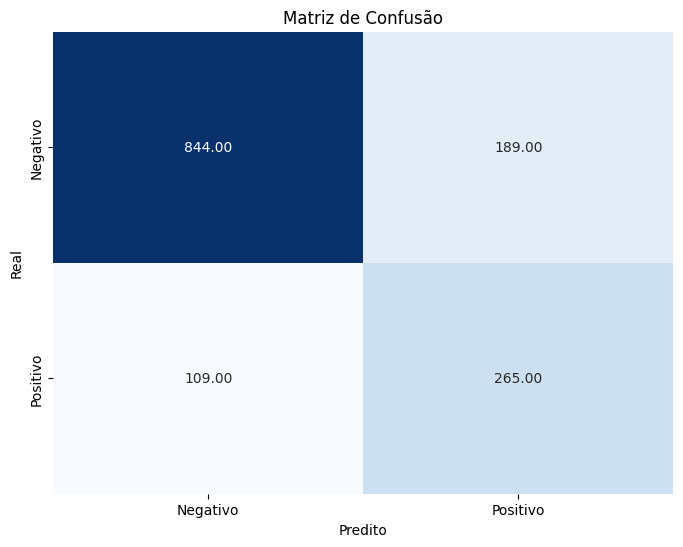

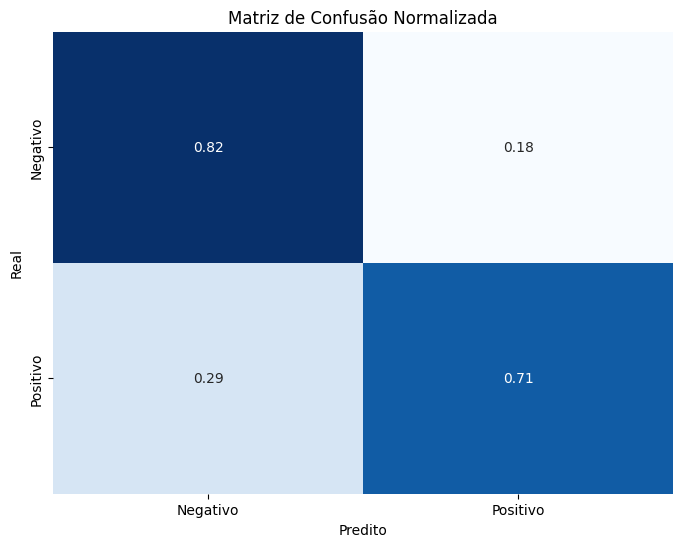

In [126]:
#combinando os dois melhores modelos
pipe = Pipeline([
    ('vot', VotingClassifier(estimators=models_list, n_jobs=-1))
])

param_grid = {
    'vot__estimators':[*[*combinations_list_2],
                        *[*combinations_list_3],
                       *[*combinations_list_4],
                       *[*combinations_list_5],
                       models_list],
    'vot__voting': ['soft'],
    'vot__flatten_transform': [True, False],
}

best_voting_f1 = get_best_model(param_grid, pipe, X_train, y_train, scorer='f1')
evaluate_model(best_voting_f1, X_test, y_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Melhores parâmetros: {'vot__flatten_transform': True, 'vot__voting': 'soft'}
Melhor Score: 0.782608695652174
ROC-AUC (test): 0.8427364873609394
Classification report (test):
              precision    recall  f1-score   support

       False       0.90      0.79      0.84      1033
        True       0.56      0.75      0.64       374

    accuracy                           0.78      1407
   macro avg       0.73      0.77      0.74      1407
weighted avg       0.81      0.78      0.79      1407

Confusion matrix (test):


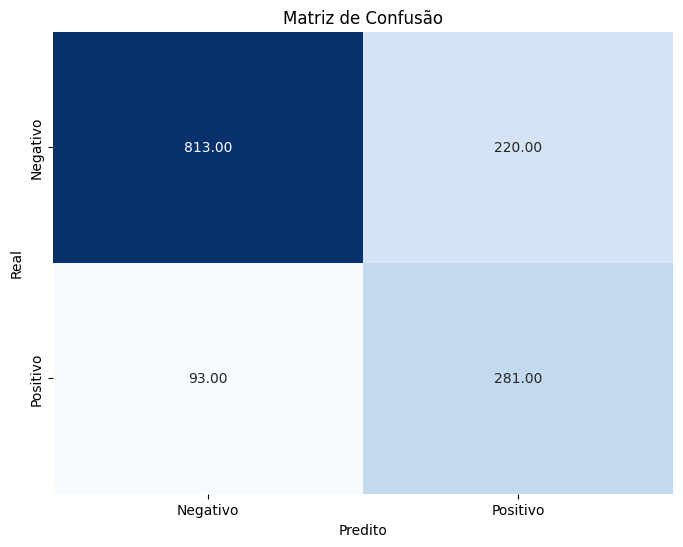

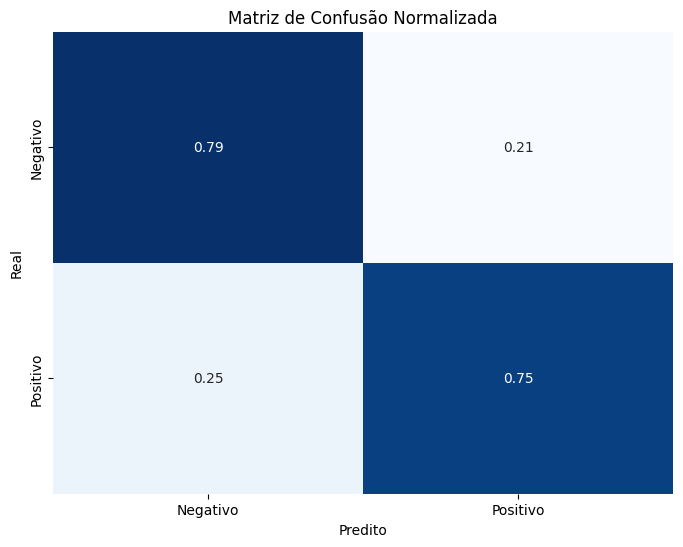

In [127]:
pipe = Pipeline([
    ('vot', VotingClassifier(estimators=[('voting_f1', best_voting_f1),
                                         ('voting_recall', best_voting)], n_jobs=-1))
])

param_grid = {
    'vot__voting': ['soft'],
    'vot__flatten_transform': [True, False],
}

best_voting_final = get_best_model(param_grid, pipe, X_train, y_train, scorer='recall')
evaluate_model(best_voting_final, X_test, y_test)
